In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Các thư viện sử dụng



In [ ]:
# common library
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt
# import glob
# from google.colab.patches import cv2_imshow
from sklearn.metrics import precision_recall_fscore_support

# tensorflow library
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, SimpleRNN
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D, MaxPooling2D
# from keras.layers import TimeDistributed, GRU, Dense, Dropout
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

from keras.applications.vgg16 import VGG16
from keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datetime import datetime
from tensorflow.data import Iterator
from tensorflow.python.framework import graph_util

from tensorflow.keras.applications import MobileNetV2

import tensorflow.keras.layers as layers

from keras.layers import GlobalAveragePooling2D

# reading data
import csv
import threading

# Label encoder
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


In [ ]:
import os
os.chdir('/content/drive/MyDrive/VietNam SignLanguage')
print(os.getcwd())

/content/drive/MyDrive/VietNam SignLanguage


# Các tham số toàn cục

In [ ]:
# some global params
SIZE = (128, 128)

# SIZE = (224, 224)
CHANNELS = 3
NBFRAME = 10
BS = 20

NUM_THREADS = 8

#preprocessing
LENGTH_TRIM = 100
classes_file = '/content/drive/MyDrive/VietNam SignLanguage/classes.npy'



# Các hàm xử lý dữ liệu

## Tiền xử lý dữ liệu

In [ ]:
# resize image by dsize = (128, 128)
def resizeImage(img, dsize):
  sizeImg = (img.shape[0],img.shape[1])
  if sizeImg != dsize and dsize != (None, None):
    img = cv2.resize(img,dsize)
  return img

# remove left right background
def removeTrimBackground(img, length = 120):
  img = img[:,length:-1*length]
  return img

def resizeScale(img, scale = 30):
  scale_percent = scale # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)

  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  return resized



In [ ]:
def preprocessingImg(img, dsize = (128,128)):
  # img = human_detection(img)
  img = removeTrimBackground(img, LENGTH_TRIM)
  img = resizeImage(img, dsize)
  return img

## Hàm đọc dữ liệu và mã hóa

In [ ]:
def readFramesThread(sema, x_data, y_data, word, path, dsize):
  sema.acquire()

  frames = os.listdir(path)
  lframes = []

  for frame in frames: # read all frames in video
    frame_path = os.path.join(path, frame)
    img = cv2.imread(frame_path, 1)
    img = preprocessingImg(img, dsize)
    lframes.append(img)

  x_data.append(lframes) # add video into list
  y_data.append(word) # add label

  # time.sleep(0.2)
  sema.release()


def readDataThread(input_path, csv_file, dsize=(128,128), listWord = None):
  x_data = []
  y_data = []

  maxthreads = NUM_THREADS
  sema = threading.Semaphore(value=maxthreads) # sema type
  threads = list()

  with open(csv_file) as csvfile: # read path from csv
    reader = csv.reader(csvfile)
    print(reader)
    for row in reader:
      # video path
      video = row[0]
      word = video.split('/')[0]

      if (listWord != None) and (word not in listWord): # decrease num classes
        continue

      # print(video)
      path = os.path.join(input_path, video)
      # execute thread
      thread = threading.Thread( target=readFramesThread, args=(sema, x_data, y_data, word, path, dsize) )
      threads.append(thread)
      thread.start()

    for t in threads: # for waiting all thread end
      t.join()

  return x_data, y_data


In [ ]:
def readFrames(path, dsize):
  frames = os.listdir(path)
  lframes = []

  for frame in frames: # read all frames in video
    frame_path = os.path.join(path, frame)
    img = cv2.imread(frame_path, 1)
    img = resizeImage(img, dsize)
    lframes.append(img)

  return lframes

def readData(input_path, csv_file, dsize=(128,128), listWord = None):
  x_data = []
  y_data = []

  with open(csv_file) as csvfile: # read path from csv
    reader = csv.reader(csvfile)
    for row in reader:
      # video path
      video = row[0]
      word = video.split('/')[0]
      # if (listWord != None) and (word not in listWord): # decrease num classes
      #   continue

      print(video)
      path = os.path.join(input_path, video)
      lframes = readFrames(path, dsize)

      x_data.append(lframes) # add video into list
      y_data.append(word) # add label

  return x_data, y_data

In [ ]:

#encoder label to train in model
def encoderLabel(y_train, y_test, classes_file = 'classes.npy', save = True):
  encoder = LabelEncoder()
  encoder.fit(y_train)

  # save classes, save as numpy array
  if save == True:
    np.save(classes_file, encoder.classes_)

  # encoder to number
  y_train1 = encoder.fit_transform(y_train)
  y_test1 = encoder.fit_transform(y_test)
  # [a,c, y,a ] -> [1,2,3,1]
  num_classes=len(np.unique(y_train))
  #encoder to binary matrix
  y_train2 = to_categorical(y_train1, num_classes=len(np.unique(y_train)))
  y_test2 = to_categorical(y_test1, num_classes=len(np.unique(y_test)))

  return y_train2, y_test2, num_classes

# Main

## Đọc dữ liệu và tiền xử lý dữ liệu

In [ ]:
start = time.time()

train_path = "/content/drive/MyDrive/VietNam SignLanguage/videoperfolder/train_dir"
train_csv = '/content/drive/MyDrive/VietNam SignLanguage/videoperfolder/train_dir_2.csv'

x_train_o, y_train_o = readDataThread(train_path, train_csv, SIZE)
end = time.time()
print('time:', end - start)

time: 137.52794075012207


In [ ]:
start = time.time()

test_path = '/content/drive/MyDrive/VietNam SignLanguage/videoperfolder/val_dir'
test_csv = '/content/drive/MyDrive/VietNam SignLanguage/videoperfolder/val_2.csv'

x_test_o, y_test_o = readDataThread(test_path, test_csv, SIZE)

end = time.time()
print('time:', end - start)

time: 38.5260009765625


In [ ]:
# convert to numpy array
x_train = np.array(x_train_o)
x_test = np.array(x_test_o)
y_train = np.array(y_train_o)
y_test = np.array(y_test_o)
print('x_train shape', x_train.shape) # (400, 10, 128, 128, 3) max 2560
print('y_train shape', y_train.shape) # (400,)
print('x_test shape', x_test.shape) # (100, 10, 128, 128, 3) max 640
print('y_test shape', y_test.shape) # (100,)

convert = False
if convert == True:
  n, nb, h, w, c = x_train.shape
  x_train= x_train.reshape(n, nb, h*w*c)
  n, nb, h, w, c = x_test.shape
  x_test= x_test.reshape(n, nb, h*w*c)

  print('x_train shape', x_train.shape) # (400, 10, 223) max 2560
  print('y_train shape', y_train.shape) # (400,)
  print('x_test shape', x_test.shape) # (100, 10, 128, 128, 3) max 640
  print('y_test shape', y_test.shape) # (100,)

x_train shape (200, 10, 128, 128, 3)
y_train shape (200,)
x_test shape (50, 10, 128, 128, 3)
y_test shape (50,)


In [ ]:
x_train = x_train /255.
x_test = x_test / 255.

## Mã hóa nhãn dữ liệu

In [ ]:
listclasses =  np.unique(y_train)
num_classes = len(listclasses)
print(num_classes)
print(listclasses)

y_train_decode, y_test_decode, num_classes = encoderLabel(y_train, y_test)

print(y_train_decode.shape)
print(y_test_decode.shape)

5
['Do' 'Hong' 'Vang' 'Xanh duong' 'Xanh la']
(200, 5)
(50, 5)


# Mô hình

## Kiến trúc mô hình

### 1. VGG16 + LSTM

In [ ]:
def load_VGG16_model(shape=(112, 112, 3)):
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=shape)
  print("Model loaded..!")
  base_model.summary()

  # model.add(Flatten())
  output1 = GlobalMaxPool2D()
  output2 = Flatten()
  module = keras.Sequential([base_model, output1, output2])
  module.summary()
  return module

def LSTMModel(shape=(5, 112, 112, 3), nbout=3):
  model = Sequential()
  convnet = load_VGG16_model(shape[1:])
  # convnet = VGG16_small(shape[1:])
  model.add(TimeDistributed(convnet, input_shape=shape))

  model.add(LSTM(64,return_sequences=True, activation='relu'))
  model.add(LSTM(128,return_sequences=True, activation = 'relu'))
  model.add(LSTM(256,return_sequences=True,activation="relu"))
  model.add(LSTM(64, return_sequences = False,activation='relu'))
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(nbout, activation='softmax'))
  sgd = keras.optimizers.SGD(learning_rate=0.00005, momentum=0.9, nesterov=True)
  # sgd = keras.optimizers.SGD( momentum=0.9, nesterov=True)
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
#Create Model
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)
# INSHAPE= ( NBFRAME, SIZE[0] * SIZE[1] * CHANNELS)  # (5, 128 * 128 * 3)
print(INSHAPE)
model = LSTMModel(INSHAPE, num_classes)
model.summary()

(10, 128, 128, 3)
Model loaded..!
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)

#### Định nghĩa và huấn luyện mô hình

In [ ]:
tic = time.time()

EPOCHS = 80
early_stoping = EarlyStopping(monitor='val_accuracy', patience=9, verbose=1, mode='max')
# save_checkpoint = ModelCheckpoint('chkp/best-weights-giang.hdf5', monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = True, mode='max')
# csv_logger = CSVLogger('chkp/training-lstm.csv', separator=",", append=False) # dùng pandas đọc
# # reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 1, min_lr = 1e-8, verbose=1)

# callbacks = [early_stoping,
#              save_checkpoint,
#              csv_logger,
#             #  reduce_lr
#              ]
# history = model.fit_generator(train,validation_data=valid,verbose=1,epochs=EPOCHS,callbacks=callbacks)
history = model.fit(x_train, y_train_decode,
            epochs=EPOCHS,
            batch_size=BS,
            shuffle=True,
            validation_data = (x_test, y_test_decode),
            verbose=1,
           )

toc = time.time()
print("TRAINING TIME: ", toc-tic)

Epoch 1/80
10/10 [==============================] - 66s 2s/step - loss: 1.6101 - accuracy: 0.2100 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 2/80
10/10 [==============================] - 9s 891ms/step - loss: 1.6093 - accuracy: 0.1900 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 3/80
10/10 [==============================] - 9s 934ms/step - loss: 1.6096 - accuracy: 0.1800 - val_loss: 1.6093 - val_accuracy: 0.2000
Epoch 4/80
10/10 [==============================] - 10s 978ms/step - loss: 1.6098 - accuracy: 0.2000 - val_loss: 1.6093 - val_accuracy: 0.2000
Epoch 5/80
10/10 [==============================] - 10s 997ms/step - loss: 1.6090 - accuracy: 0.2150 - val_loss: 1.6092 - val_accuracy: 0.2000
Epoch 6/80
10/10 [==============================] - 10s 1s/step - loss: 1.6092 - accuracy: 0.2050 - val_loss: 1.6092 - val_accuracy: 0.2000
Epoch 7/80
10/10 [==============================] - 10s 1s/step - loss: 1.6100 - accuracy: 0.2050 - val_loss: 1.6091 - val_accuracy: 0.2000
Epoch 8/80

#### Lịch sử huấn luyện

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


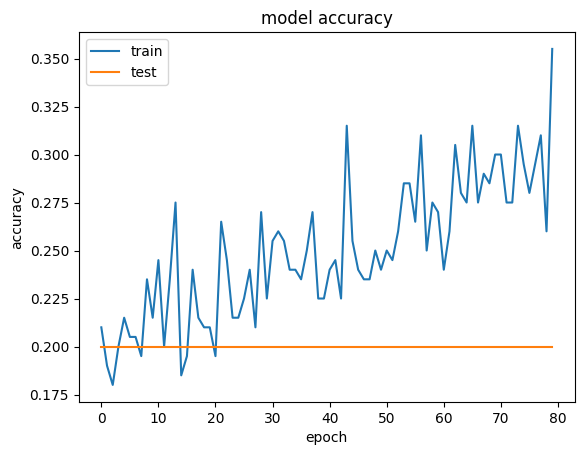

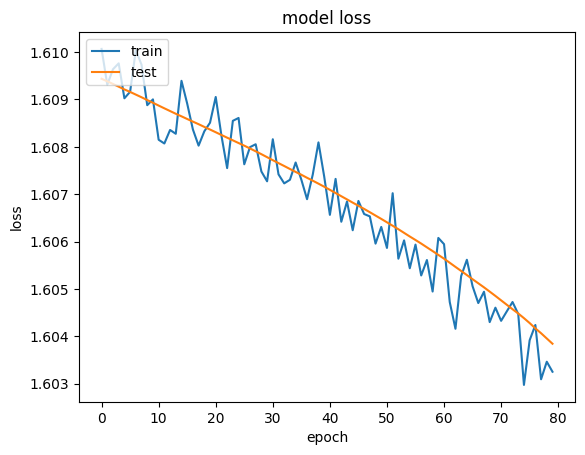

In [ ]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/VietNam SignLanguage/LSTM-VGG16_NoAug.keras")

 ### 2. ResNet-50 và LSTM

#### Định nghĩa và huấn luyện mô hình

In [ ]:
def load_ResNet50_model(shape=(112, 112, 3)):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=shape)
    print("ResNet50 Model loaded..!")
    base_model.summary()

    output = GlobalAveragePooling2D()
    module = keras.Sequential([base_model, output])
    module.summary()
    return module

def LSTMModel(shape=(5, 112, 112, 3), nbout=3):
    model = Sequential()
    convnet = load_ResNet50_model(shape[1:])
    model.add(TimeDistributed(convnet, input_shape=shape))

    model.add(LSTM(64,return_sequences=True, activation='relu'))
    model.add(LSTM(128,return_sequences=True, activation = 'relu'))
    model.add(LSTM(256,return_sequences=True,activation="relu"))
    model.add(LSTM(64, return_sequences = False,activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nbout, activation='softmax'))
    sgd = keras.optimizers.SGD(learning_rate=0.00005, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
#Create Model
INSHAPE = (NBFRAME, 128, 128, 3)

# Create the model
model = LSTMModel(INSHAPE, num_classes)
model.summary()

94765736/94765736 [==============================] - 2s 0us/step
ResNet50 Model loaded..!
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 

In [ ]:
tic = time.time()

EPOCHS = 80
early_stoping = EarlyStopping(monitor='val_accuracy', patience=9, verbose=1, mode='max')
# save_checkpoint = ModelCheckpoint('/content/drive/MyDrive/VietNam SignLanguage/best-weights-giang.hdf5', monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = True, mode='max')
# csv_logger = CSVLogger('/content/drive/MyDrive/VietNam SignLanguage/training-resnet-lstm.csv', separator=",", append=False) # dùng pandas đọc
# reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 1, min_lr = 1e-8, verbose=1)

# callbacks = [early_stoping,
#              save_checkpoint,
#              csv_logger,
#             #  reduce_lr
#              ]
history = model.fit(x_train, y_train_decode,
            epochs=EPOCHS,
            batch_size=BS,
            shuffle=True,
            validation_data = (x_test, y_test_decode),
            verbose=1,
           )

toc = time.time()
print("TRAINING TIME: ", toc-tic)

Epoch 1/80
10/10 [==============================] - 48s 2s/step - loss: 1.6032 - accuracy: 0.2300 - val_loss: 1.6169 - val_accuracy: 0.2000
Epoch 2/80
10/10 [==============================] - 9s 912ms/step - loss: 1.5909 - accuracy: 0.2450 - val_loss: 1.6244 - val_accuracy: 0.2000
Epoch 3/80
10/10 [==============================] - 9s 908ms/step - loss: 1.5805 - accuracy: 0.2550 - val_loss: 1.6429 - val_accuracy: 0.1800
Epoch 4/80
10/10 [==============================] - 9s 897ms/step - loss: 1.5530 - accuracy: 0.2800 - val_loss: 1.6519 - val_accuracy: 0.2000
Epoch 5/80
10/10 [==============================] - 9s 884ms/step - loss: 1.5200 - accuracy: 0.3550 - val_loss: 1.6591 - val_accuracy: 0.2000
Epoch 6/80
10/10 [==============================] - 9s 902ms/step - loss: 1.4990 - accuracy: 0.4200 - val_loss: 1.6652 - val_accuracy: 0.2000
Epoch 7/80
10/10 [==============================] - 9s 899ms/step - loss: 1.4692 - accuracy: 0.4350 - val_loss: 1.6596 - val_accuracy: 0.1800
Epoch 8/

In [ ]:
model.save("/content/drive/MyDrive/VietNam SignLanguage/LSTM-ResNet_NoAug.keras")

#### Lịch sử huấn luyện

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


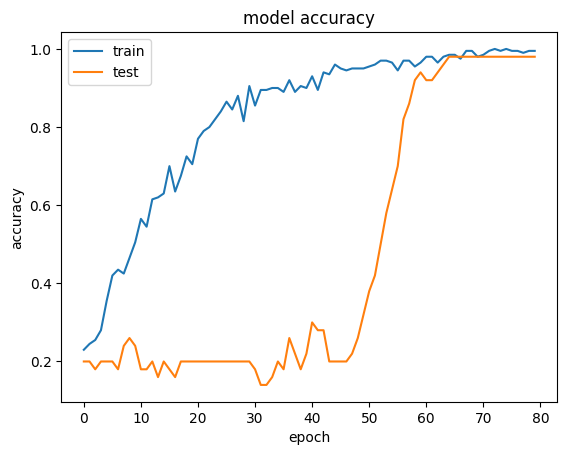

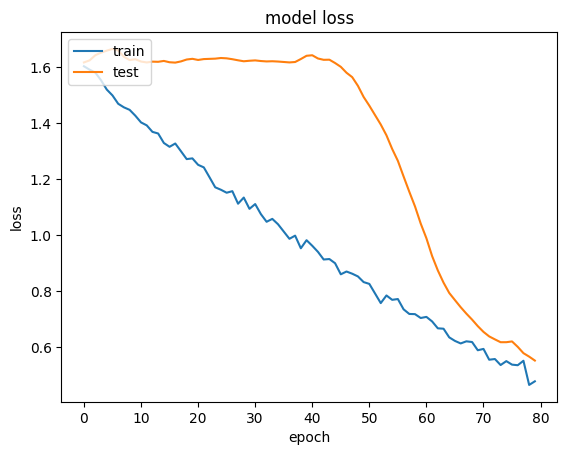

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### MobileNet

#### Định nghĩa và huấn luyện mô hình

In [ ]:
def load_MobileNet_model(shape=(112, 112, 3)):
  base_model =  MobileNetV2(weights='imagenet', include_top=False, input_shape=shape)
  print("Model loaded..!")
  base_model.summary()

  # model.add(Flatten())
  output1 = GlobalMaxPool2D()
  output2 = Flatten()
  module = keras.Sequential([base_model, output1, output2])
  module.summary()
  return module

def LSTMModel(shape=(5, 112, 112, 3), nbout=3):
  model = Sequential()
  convnet = load_MobileNet_model(shape[1:])
  model.add(TimeDistributed(convnet, input_shape=shape))
  model.add(LSTM(64,return_sequences=True, activation='relu'))
  model.add(LSTM(128,return_sequences=True, activation = 'relu'))
  model.add(LSTM(256,return_sequences=True,activation="relu"))
  model.add(LSTM(64, return_sequences = False,activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(nbout, activation='softmax'))
  sgd = keras.optimizers.SGD(learning_rate=0.00005, momentum=0.9, nesterov=True)
  # sgd = keras.optimizers.SGD( momentum=0.9, nesterov=True)
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
#Create Model
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)
# INSHAPE= ( NBFRAME, SIZE[0] * SIZE[1] * CHANNELS)  # (5, 128 * 128 * 3)
print(INSHAPE)
model = LSTMModel(INSHAPE, num_classes)
model.summary()

(10, 128, 128, 3)
9406464/9406464 [==============================] - 0s 0us/step
Model loaded..!
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDi  (None, 10, 1280)          2257984   
 stributed)                                                      
                                                                 
 lstm_5 (LSTM)               (None, 10, 64)            344320    
                                                                 
 lstm_6 (LSTM)               (None, 10, 128)           98816     
                                                                 
 lstm_7 (LSTM)               (None, 10, 256)           394240    
                                                                 
 lstm_8 (LSTM)               (None, 64)                82176     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                      

In [ ]:
tic = time.time()

EPOCHS = 80
early_stoping = EarlyStopping(monitor='val_accuracy', patience=9, verbose=1, mode='max')
# save_checkpoint = ModelCheckpoint('/content/drive/MyDrive/VietNam SignLanguage/best-weights-giang.hdf5', monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = True, mode='max')
# csv_logger = CSVLogger('/content/drive/MyDrive/VietNam SignLanguage/training-resnet-lstm.csv', separator=",", append=False) # dùng pandas đọc
# reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 1, min_lr = 1e-8, verbose=1)

# callbacks = [early_stoping,
#              save_checkpoint,
#              csv_logger,
#             #  reduce_lr
#              ]
history = model.fit(x_train, y_train_decode,
            epochs=EPOCHS,
            batch_size=BS,
            shuffle=True,
            validation_data = (x_test, y_test_decode),
            verbose=1,
           )

toc = time.time()
print("TRAINING TIME: ", toc-tic)

Epoch 1/80
10/10 [==============================] - 45s 2s/step - loss: 1.6426 - accuracy: 0.2450 - val_loss: 1.6441 - val_accuracy: 0.2000
Epoch 2/80
10/10 [==============================] - 4s 394ms/step - loss: 1.6753 - accuracy: 0.1650 - val_loss: 1.6301 - val_accuracy: 0.2400
Epoch 3/80
10/10 [==============================] - 4s 394ms/step - loss: 1.6437 - accuracy: 0.1650 - val_loss: 1.6341 - val_accuracy: 0.2000
Epoch 4/80
10/10 [==============================] - 4s 411ms/step - loss: 1.6478 - accuracy: 0.1800 - val_loss: 1.6285 - val_accuracy: 0.1600
Epoch 5/80
10/10 [==============================] - 4s 392ms/step - loss: 1.6740 - accuracy: 0.2050 - val_loss: 1.6325 - val_accuracy: 0.1800
Epoch 6/80
10/10 [==============================] - 4s 400ms/step - loss: 1.6250 - accuracy: 0.1800 - val_loss: 1.6129 - val_accuracy: 0.2200
Epoch 7/80
10/10 [==============================] - 4s 409ms/step - loss: 1.6236 - accuracy: 0.2200 - val_loss: 1.6032 - val_accuracy: 0.2000
Epoch 8/

In [ ]:
model.save("/content/drive/MyDrive/VietNam SignLanguage/LSTM-MobileNet_NoAug.keras")

#### Lịch sử huấn luyện

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


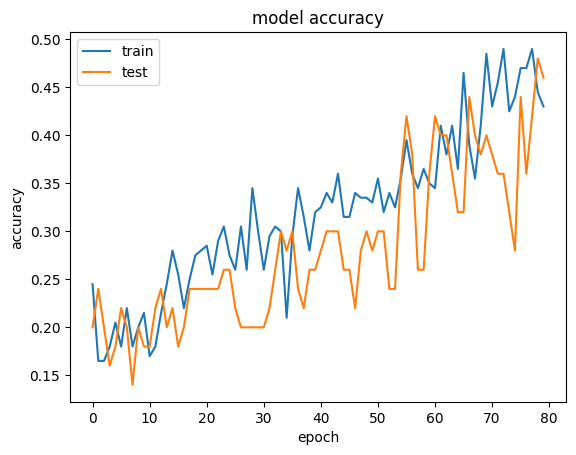

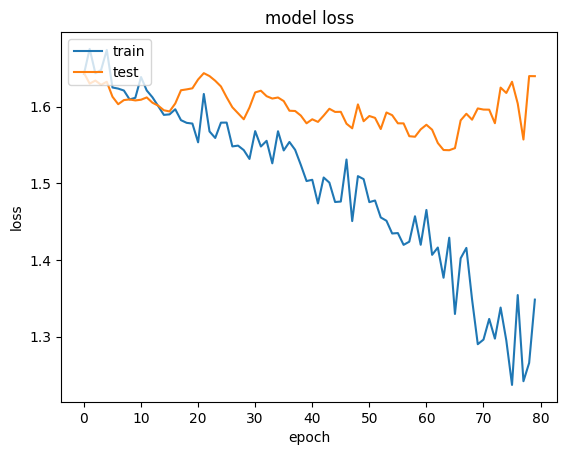

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Kiểm thử mô hình

## 1. VGG16 + LSTM

In [ ]:
# common library
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt
# import glob
# from google.colab.patches import cv2_imshow

# tensorflow library
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, SimpleRNN
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D, MaxPooling2D
# from keras.layers import TimeDistributed, GRU, Dense, Dropout
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

from keras.applications.vgg16 import VGG16

# reading data
import csv
import threading

# Label encoder
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# some global params
SIZE = (128,128)
# SIZE = (64,64)
# SIZE = (224, 224)
CHANNELS = 3
NBFRAME = 10
BS = 20

NUM_THREADS = 8

#preprocessing
LENGTH_TRIM = 130
def load_VGG16_model(shape=(112, 112, 3)):
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=shape)
  print("Model loaded..!")
  base_model.summary()

  output1 = GlobalMaxPool2D()
  output2 = Flatten()
  module = keras.Sequential([base_model, output1, output2])
  module.summary()
  return module

def LSTMModel(shape=(5, 112, 112, 3), nbout=3):
  model = Sequential()
  convnet = load_VGG16_model(shape[1:])
  # convnet = VGG16_small(shape[1:])
  model.add(TimeDistributed(convnet, input_shape=shape))
  model.add(LSTM(64,return_sequences=True, activation='relu'))
  model.add(LSTM(128,return_sequences=True, activation = 'relu'))
  model.add(LSTM(256,return_sequences=True,activation="relu"))
  model.add(LSTM(64, return_sequences = False,activation='relu'))
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(nbout, activation='softmax'))
  sgd = keras.optimizers.SGD(learning_rate=0.00005, momentum=0.9, nesterov=True)
  # sgd = keras.optimizers.SGD( momentum=0.9, nesterov=True)
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model
classes_file = '/content/drive/MyDrive/VietNam SignLanguage/classes.npy'
encoder = LabelEncoder()
encoder.classes_ = np.load(classes_file)
classes = np.array(encoder.classes_)
num_classes = len(classes)
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (2560, 5, 112, 112, 3)
print(classes)
# print(INSHAPE)
model = LSTMModel(INSHAPE, num_classes)
model.load_weights('/content/drive/MyDrive/VietNam SignLanguage/LSTM-VGG16_NoAug.keras')

print(num_classes,classes)

['Do' 'Hong' 'Vang' 'Xanh duong' 'Xanh la']
Model loaded..!
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 

5 ['Do' 'Hong' 'Vang' 'Xanh duong' 'Xanh la']


In [ ]:
# resize image by dsize = (128, 128)
def resizeImage(img, dsize):
  sizeImg = (img.shape[0],img.shape[1])
  if sizeImg != dsize and dsize != (None, None):
    img = cv2.resize(img,dsize)
  return img

# remove left right background
def removeTrimBackground(img, length = 120):
  img = img[:,length:-1*length]
  return img

def resizeScale(img, scale = 30):
  scale_percent = scale # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)

  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  return resized

def preprocessingImg(img, dsize = (128,128)):
  # img = human_detection(img)
  img = removeTrimBackground(img, LENGTH_TRIM)
  img = resizeImage(img, dsize)
  return img

In [ ]:
class MyVideo:
  def __init__(self, path='', root_path=''):
    self.path = path
    self.root = root_path
    self.video = cv2.VideoCapture(path)
    self.name = path.split("/")[-1]
    self.label = path.split("/")[-2]
  def getVideo(self):
    return self.video
  def getFullPath(self):
    return self.root + '/' + self.path
  def getFileName(self):
    return self.name
  def getFrameCount(self):
    return int(self.video.get(cv2.CAP_PROP_FRAME_COUNT))
  def getLabel(self):
    return self.label
  def release(self):
    self.video.release()
    del self


def videotoframe(myVideo, dsize=(128,128) , numframe=5, start=0, stop=0):
  listframe = []
  length = myVideo.getFrameCount()
  currentFrame = -1
  skipframe = int((length - start - stop)/numframe)
  takeframe = skipframe + start
  taken = 0
  # print('video',video,'length', length, 'skip', skipframe)
  video = myVideo.getVideo()
  while(True):
      # Capture frame-by-frame
      ret, frame = video.read()
      currentFrame += 1

      if ret == False:
          break
      if currentFrame < takeframe:
          continue
      if taken >= numframe:
          break
      frame = resizeScale(frame)
      frame = removeTrimBackground(frame, LENGTH_TRIM)
      frame = resizeImage(frame, dsize)
      listframe.append(frame)

      takeframe += skipframe
      taken += 1
  # When everything done, release the capture
  myVideo.release()
  cv2.destroyAllWindows()
  return listframe
def preprocessingVideo(myVideo):
  frames = videotoframe(myVideo, SIZE, NBFRAME, 10, 30)
  frames = np.array(frames)
  frames = frames / 255.
  return frames

def predictOneVideo(video, classes):
  # preprocessing video pat
  if type(video) is not MyVideo:
    video = MyVideo(video)
    print(video)
  item = preprocessingVideo(video)
  item = item[None,:]  # [640,10,64,64,3]
  try:
    # a = model.predict_classes(item) # old version
    predicted = np.argmax(model.predict(item), axis=-1) # [10] [15,12]
    return classes[predicted[0]]  # [16] accept
  except:
    print('Video', video.name,'has error')
    return 'Null'
  # print(predicted)

def preparePath(path, csv_file = ''):
  paths = []
  if csv_file == '':
    videos = os.listdir(path)
    for video in videos:
        video_path = os.path.join(path, video)
        paths.append(video_path)
  else:
    with open(csv_file) as csvfile: # read path from csv
      reader = csv.reader(csvfile)
      for row in reader:
        video_path = os.path.join(path, row[0])
        paths.append(video_path)

  print(len(paths))
  return paths

In [ ]:

def predictVideoOneTime(paths, classes, model, verbose=0):
    data = []
    names = []
    expecteds = []
    n = len(paths)
    for path in paths:
        myVideo = MyVideo(path)
        item = preprocessingVideo(myVideo)
        data.append(item)
        names.append(myVideo.getFileName())
        expecteds.append(myVideo.getLabel())

    data = np.array(data)
    predicted = np.argmax(model.predict(data), axis=-1)

    dic = {}
    count = 0
    y_true = []
    y_pred = []
    for i in range(n):
        expected = expecteds[i].split('\\')[1]
        text = 'Video: ' + names[i] + ' Expected: ' + expected + ' Predicted: ' + classes[predicted[i]]
        if expected not in dic:
            dic[expected] = 0
        if expected == classes[predicted[i]]:
            count = count + 1
            dic[expected] = dic[expected] + 1
        else:
            text = '\x1b[31m' + text + '\x1b[0m'
        if verbose == 1:
            print(text)
        y_true.append(expected)
        y_pred.append(classes[predicted[i]])

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1score = f1_score(y_true, y_pred, average='weighted')

    print()
    print('Accuracy:', str(count) + '/' + str(n), ',', str(count / n))
    print('Precision:', precision)
    print('Recall Score:', recall)
    print('F1 Score:', f1score)
    return dic, precision, recall, f1score
def predictVideoOneByOne(paths, classes, verbose=0):
    dic = {}
    y_true = []
    y_pred = []

    count = 0
    n = len(paths)
    index = 1
    for video in paths:
        my = MyVideo(video)
        predicted = predictOneVideo(myVideo, classes)
        expected = myVideo.getLabel()
        y_true.append(expected)
        y_pred(predicted)
        print(index, end=' ')
        text = 'Video: ' + myVideo.getFileName() + ' Expected: ' + expected + ' Predicted: ' + predicted
        if expected not in dic:
            dic[expected] = 0
        if expected == predicted:
            count = count + 1
            dic[expected] = dic[expected] + 1
        else:
            text = '\x1b[31m' + text + '\x1b[0m'
        index = index + 1
        if verbose == 1:
            print(text)

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    print()
    print('Accuracy:', str(count) + '/' + str(n), ',', str(count / n))
    print('Precision Score:', precision)
    print('Recall Score:', recall)
    return dic, precision, recall

def predictVideoOneByOneReturn2dDict(paths, classes, model, verbose=0):
    dic = {}
    count = 0
    n = len(paths)
    index = 0
    y_true = []
    y_pred = []

    for video in paths:
        myVideo = MyVideo(video)
        predicted = predictOneVideo(myVideo, classes)
        expected = myVideo.getLabel()
        print(index+1, end=' ')
        text = 'Video: '+ myVideo.getFileName() + ' Expected: '+ expected + ' Predicted: '+ predicted

        if expected not in dic:
            dic[expected] = {}
        if predicted not in dic[expected]:
            dic[expected][predicted] = 0

        if expected == predicted:
            count = count + 1

        else:
            text = '\x1b[31m'+ text + '\x1b[0m'

        dic[expected][predicted] += 1
        y_true.append(expected)
        y_pred.append(predicted)

        index = index + 1
        if verbose == 1 :
            print(text)

    precision, recall, f1score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    print()
    print('Accuracy:', str(count)+'/'+str(n), ',', str(count/n))
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1score)

    return dic, precision, recall, f1score
def predictVideo(path, csv_file, classes, verbose = 0 ,isOneTime = False):
  paths = preparePath(path, csv_file)

  if isOneTime == True:
    dic = predictVideoOneTime(paths, classes, verbose)
  else:
    dic = predictVideoOneByOneReturn2dDict(paths, classes, verbose)
  return dic

###  Đánh giá trên tập đánh giá

In [ ]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_decode, axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_true_classes, y_pred_classes))


2/2 [==============================] - 111s 39s/step
              precision    recall  f1-score   support

           0       0.33      0.30      0.32        10
           1       0.00      0.00      0.00        10
           2       0.25      1.00      0.40        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10

    accuracy                           0.26        50
   macro avg       0.12      0.26      0.14        50
weighted avg       0.12      0.26      0.14        50



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Đánh giá trên tập kiểm thử (video tự quay)

In [ ]:
classes_file = '/content/drive/MyDrive/VietNam SignLanguage/classes.npy'
encoder = LabelEncoder()
encoder.classes_ = np.load(classes_file)
classes = np.array(encoder.classes_)
num_classes = len(classes)
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (2560, 5, 112, 112, 3)
print(classes)
res = predictVideo(
    path="/content/drive/MyDrive/VietNam SignLanguage/train_test/test_dir",
    csv_file='/content/drive/MyDrive/VietNam SignLanguage/videoperfolder/test_dir_2.csv',
    classes=classes,
    verbose=1,
    isOneTime = False)

['Do' 'Hong' 'Vang' 'Xanh duong' 'Xanh la']
50
1/1 [==============================] - 2s 2s/step
50 
Accuracy: 10/50 , 0.2
Precision: 0.04
Recall: 0.2
F1 Score: 0.06666666666666668


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## ResNet + LSTM

In [ ]:
# common library
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt
# import glob
# from google.colab.patches import cv2_imshow

# tensorflow library
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, SimpleRNN
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D, MaxPooling2D
# from keras.layers import TimeDistributed, GRU, Dense, Dropout
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

# reading data
import csv
import threading

# Label encoder
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# some global params
# SIZE = (64, 64)
SIZE = (128,128)

# SIZE = (224, 224)
CHANNELS = 3
NBFRAME = 10
BS = 20

NUM_THREADS = 8

#preprocessing
LENGTH_TRIM = 130
def load_ResNet50_model(shape=(112, 112, 3)):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=shape)
    print("ResNet50 Model loaded..!")
    base_model.summary()

    output = GlobalAveragePooling2D()
    module = keras.Sequential([base_model, output])
    module.summary()
    return module

def LSTMModel(shape=(5, 112, 112, 3), nbout=3):
    model = Sequential()
    convnet = load_ResNet50_model(shape[1:])
    model.add(TimeDistributed(convnet, input_shape=shape))

    model.add(LSTM(64,return_sequences=True, activation='relu'))
    model.add(LSTM(128,return_sequences=True, activation = 'relu'))
    model.add(LSTM(256,return_sequences=True,activation="relu"))
    model.add(LSTM(64, return_sequences = False,activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nbout, activation='softmax'))
    sgd = keras.optimizers.SGD(learning_rate=0.00005, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
classes_file = '/content/drive/MyDrive/VietNam SignLanguage/classes.npy'
encoder = LabelEncoder()
encoder.classes_ = np.load(classes_file)
classes = np.array(encoder.classes_)
num_classes = len(classes)
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (2560, 5, 112, 112, 3)
print(classes)
# print(INSHAPE)
model = LSTMModel(INSHAPE, num_classes)
model.load_weights('/content/drive/MyDrive/VietNam SignLanguage/LSTM-ResNet_NoAug.keras')

print(num_classes,classes)

### Đánh giá trên tập đánh giá

In [ ]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_decode, axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_true_classes, y_pred_classes))


2/2 [==============================] - 49s 18s/step
              precision    recall  f1-score   support

           0       0.20      0.90      0.33        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.17      0.10      0.12        10

    accuracy                           0.20        50
   macro avg       0.07      0.20      0.09        50
weighted avg       0.07      0.20      0.09        50



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Đánh giá trên tập kiểm thử (video tự quay)

In [ ]:
classes_file = '/content/drive/MyDrive/VietNam SignLanguage/classes.npy'
encoder = LabelEncoder()
encoder.classes_ = np.load(classes_file)
classes = np.array(encoder.classes_)
num_classes = len(classes)
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (2560, 5, 112, 112, 3)
print(classes)
res = predictVideo(
    path="/content/drive/MyDrive/VietNam SignLanguage/train_test/test_dir",
    csv_file='/content/drive/MyDrive/VietNam SignLanguage/videoperfolder/test_dir_2.csv',
    classes=classes,
    verbose=1,
    isOneTime = False)

## MobileNet + LSTM

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import load_model
from keras.datasets import mnist
from keras.utils import to_categorical

In [ ]:
# common library
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt
# import glob
# from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datetime import datetime
from tensorflow.data import Iterator
from tensorflow.python.framework import graph_util

from tensorflow.keras.applications import MobileNetV2
# tensorflow library
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, SimpleRNN
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D, MaxPooling2D
# from keras.layers import TimeDistributed, GRU, Dense, Dropout
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

from keras.applications.vgg16 import VGG16

# reading data
import csv
import threading

# Label encoder
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# some global params
SIZE = (128, 128)

# SIZE = (224, 224)
CHANNELS = 3
NBFRAME = 10
BS = 20

NUM_THREADS = 8

#preprocessing
LENGTH_TRIM = 130
def load_MobileNet_model(shape=(112, 112, 3)):
  base_model =  MobileNetV2(weights='imagenet', include_top=False, input_shape=shape)
  print("Model loaded..!")
  base_model.summary()

  # model.add(Flatten())
  output1 = GlobalMaxPool2D()
  output2 = Flatten()
  module = keras.Sequential([base_model, output1, output2])
  module.summary()
  return module

def LSTMModel(shape=(5, 112, 112, 3), nbout=3):
  model = Sequential()
  convnet = load_MobileNet_model(shape[1:])
  # convnet = VGG16_small(shape[1:])
  model.add(TimeDistributed(convnet, input_shape=shape))
  model.add(LSTM(64,return_sequences=True, activation='relu'))
  model.add(LSTM(128,return_sequences=True, activation = 'relu'))
  model.add(LSTM(256,return_sequences=True,activation="relu"))
  model.add(LSTM(64, return_sequences = False,activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(nbout, activation='softmax'))
  sgd = keras.optimizers.SGD(learning_rate=0.00005, momentum=0.9, nesterov=True)
  # sgd = keras.optimizers.SGD( momentum=0.9, nesterov=True)
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model
classes_file = '/content/drive/MyDrive/VietNam SignLanguage/classes.npy'
encoder = LabelEncoder()
encoder.classes_ = np.load(classes_file)
classes = np.array(encoder.classes_)
num_classes = len(classes)
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (2560, 5, 112, 112, 3)
print(classes)
# print(INSHAPE)
model = LSTMModel(INSHAPE, num_classes)
model.load_weights('/content/drive/MyDrive/VietNam SignLanguage/LSTM-MobileNet_NoAug.keras')

print(num_classes,classes)

['Do' 'Hong' 'Vang' 'Xanh duong' 'Xanh la']
9406464/9406464 [==============================] - 1s 0us/step
Model loaded..!
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_15[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                       

5 ['Do' 'Hong' 'Vang' 'Xanh duong' 'Xanh la']


### Đánh giá trên tập đánh giá

In [ ]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_decode, axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_true_classes, y_pred_classes))


2/2 [==============================] - 9s 3s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.18      0.40      0.25        10
           2       0.27      0.70      0.39        10
           3       0.00      0.00      0.00        10
           4       1.00      0.10      0.18        10

    accuracy                           0.24        50
   macro avg       0.29      0.24      0.16        50
weighted avg       0.29      0.24      0.16        50



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Đánh giá trên tập kiểm thử (video tự quay)

In [ ]:
classes_file = '/content/drive/MyDrive/VietNam SignLanguage/classes.npy'
encoder = LabelEncoder()
encoder.classes_ = np.load(classes_file)
classes = np.array(encoder.classes_)
num_classes = len(classes)
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (2560, 5, 112, 112, 3)
print(classes)
res = predictVideo(
    path="/content/drive/MyDrive/VietNam SignLanguage/train_test/test_dir",
    csv_file='/content/drive/MyDrive/VietNam SignLanguage/videoperfolder/test_dir_2.csv',
    classes=classes,
    verbose=1,
    isOneTime = False)

['Do' 'Hong' 'Vang' 'Xanh duong' 'Xanh la']
50
1/1 [==============================] - 0s 111ms/step
50 
Accuracy: 11/50 , 0.22
Precision: 0.12100000000000001
Recall: 0.22
F1 Score: 0.15022222222222223


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
